In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import shapely
import os.path
import time

from pathlib import Path
from shapely import voronoi_polygons, MultiPoint, unary_union
from shapely.ops import nearest_points
from sklearn.cluster import KMeans
from geovoronoi import voronoi_regions_from_coords, points_to_coords

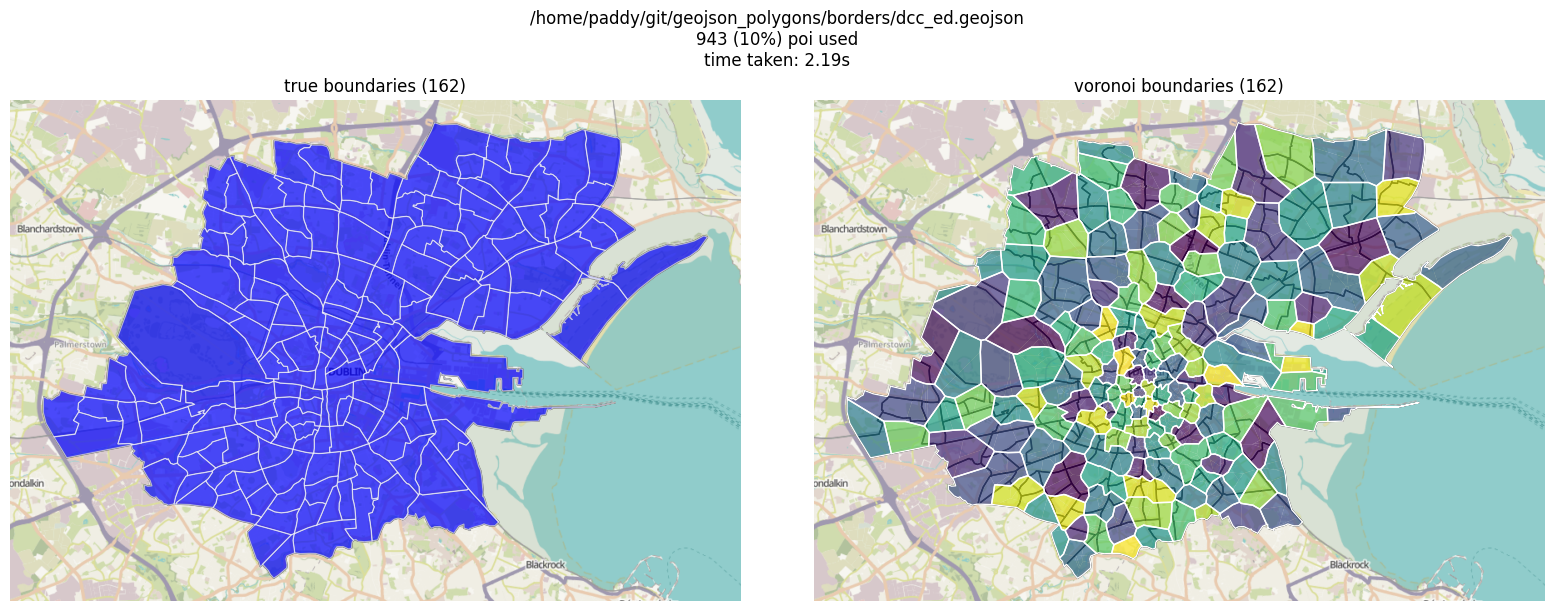

In [ ]:



org_dir = "geojson_polygons/dcc.geojson"
poi_dir = "geojson_polygons/geofabrik_dcc_bounding.geojson"

def bound_compare_voronoi(org_dir, poi_dir, epsg=3857, sample=0.1):
    start_time = time.time()
    
    # loading bounds and poi
    org_bounds = gpd.read_file(org_dir).to_crs(epsg)
    org_bounds.geometry = org_bounds.geometry.force_2d()
    poi = gpd.read_file(poi_dir).to_crs(epsg)
    poi = gpd.sjoin(poi, org_bounds)
    poi_sample = round(len(poi)*sample)

    # sampling poi
    poi = poi.sample(poi_sample) if sample < 1 else poi
    if poi_sample < len(org_bounds):
        print(f"poi sample ({poi_sample}) should be > number of original polygons ({len(org_bounds)})")
        print("adjust 'sample' and try again.")
        return
    
    # generating initial voronoi polygons
    boundary_shape = unary_union(org_bounds['geometry'])
    coords = points_to_coords(poi['geometry'])
    region_polys, _ = voronoi_regions_from_coords(coords, boundary_shape)
    poi_vor = gpd.GeoDataFrame(geometry=list(region_polys.values()), crs=epsg)

    # kmeans clustering for new voronoi centroids
    feature_coords = np.array([[e.x, e.y] for e in poi['geometry']])
    kmeans = KMeans(len(org_bounds['geometry']))
    kmeans.fit(feature_coords)
    centroids = kmeans.cluster_centers_
    df = pd.DataFrame(centroids, columns=['x', 'y'])
    poi_clust = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df.x, df.y), crs=3857)

    # classifying constituent voronoi by their distance to cluster centroids
    poi_vor['clust'] = poi_vor.geometry.centroid.apply(lambda g: poi_clust.geometry.distance(g)).apply(np.argmin, axis=1)
    poi_vor_clust = poi_vor.dissolve(by='clust')

    end_time = time.time()

    # plotting
    fig, axs = plt.subplots(1,2,figsize=(16,6), constrained_layout=True)
    fig.suptitle(f"{org_dir}\n{poi_sample} ({int(sample*100)}%) poi used\ntime taken: {end_time - start_time:.2f}s")
    for ax in axs:
        ax.axis('off')
        org_bounds.plot(ax=ax, facecolor='none', edgecolor='black')
        cx.add_basemap(ax, crs=3857, attribution=False)

    axs[0].set_title(f"true boundaries ({len(org_bounds)})")
    org_bounds.plot(ax=axs[0], facecolor='blue', edgecolor='white', alpha=0.7)

    axs[1].set_title(f"voronoi boundaries ({len(poi_vor_clust)})")
    poi_vor.plot(ax=axs[1], edgecolor='none', column='clust', cmap='viridis', alpha=0.7)
    poi_vor_clust.dissolve(by='clust').plot(ax=axs[1], facecolor='none', edgecolor='white')

    plt.show()

geojson_path = os.path.join(os.path.dirname(os.getcwd()), "geojson_polygons/borders")

dublin_bounds = os.path.join(geojson_path,"dcc_ed.geojson")
dublin_poi = os.path.join(geojson_path,"dublin_poi.geojson")

london_bounds = os.path.join(geojson_path,"london_wards.geojson")
london_poi = os.path.join(geojson_path,"london_poi.geojson")

ireland_bounds = os.path.join(geojson_path,"ireland_counties.geojson")
ireland_poi = os.path.join(geojson_path,"ireland_poi.geojson")

epsg = 3857

#for x in np.linspace(0.1,0.1,1):
bound_compare_voronoi(dublin_bounds, dublin_poi, epsg, 0.1)

In [ ]:
def voronoi_from_points(bounds, points, n):
    # takes in a polygon boundary (single or multi), a collection of points, and generates the appropriate number of Voronoi polygons
    boundary = unary_union(bounds['geometry'])
    coords = points_to_coords(points['geometry'])
    region_polys, _ = voronoi_regions_from_coords(coords, boundary)
    gdf_vor = gpd.GeoDataFrame(geometry=list(region_polys.values()), crs=epsg)

    # kmeans clustering for new voronoi centroids
    feature_coords = np.array([[e.x, e.y] for e in points['geometry']])
    kmeans = KMeans(n)
    kmeans.fit(feature_coords)
    centroids = kmeans.cluster_centers_
    df = pd.DataFrame(centroids, columns=['x', 'y'])
    gdf_clust = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df.x, df.y), crs=3857)

    # classifying constituent voronoi by their distance to cluster centroids
    gdf_vor['clust'] = gdf_vor.geometry.centroid.apply(lambda g: gdf_clust.geometry.distance(g)).apply(np.argmin, axis=1)
    gdf_vor = gdf_vor.dissolve(by='clust')

    return gdf_vor


def poi_voronoi(org_dir, poi_dir, epsg=3857, sample=0.1):    
    org_bounds = gpd.read_file(org_dir).to_crs(epsg)
    org_bounds.geometry = org_bounds.geometry.force_2d()
    poi = gpd.read_file(poi_dir).to_crs(epsg)
    poi = gpd.sjoin(poi, org_bounds)
    poi_sample = round(len(poi)*sample)

    # sampling poi
    poi = poi.sample(poi_sample) if sample < 1 else poi
    if poi_sample < len(org_bounds):
        print(f"poi sample ({poi_sample}) should be > number of original polygons ({len(org_bounds)})")
        print("adjust 'sample' and try again.")
        return
    
    vor_districts = voronoi_from_points(org_bounds, poi, 6)

    return vor_districts
    
    

dublin_bounds = os.path.join(geojson_path,"dcc_ed.geojson")
dublin_poi = os.path.join(geojson_path,"dublin_poi.geojson")
epsg = 3857

poi_vor = poi_voronoi(dublin_bounds, dublin_poi, epsg, 0.1)

X (1500, 1500)
[[ 6  6  6 ...  2  2  2]
 [ 6  6  6 ...  2  2  2]
 [ 6  6  6 ...  2  2  2]
 ...
 [17 17 17 ... 10 10 10]
 [17 17 17 ... 10 10 10]
 [17 17 17 ... 10 10 10]]


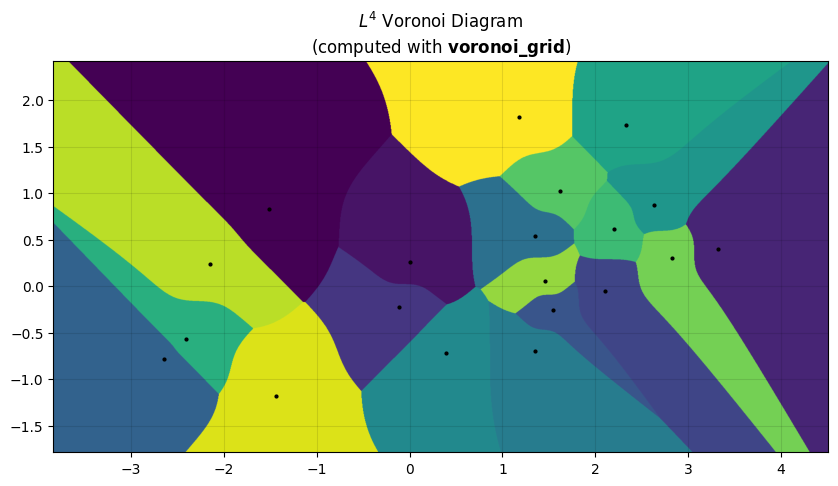

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import shapely
import os.path
import time

from pathlib import Path
from shapely.ops import nearest_points
from sklearn.cluster import KMeans
from geovoronoi import voronoi_regions_from_coords, points_to_coords

# Copyright © 2021 Warren Weckesser

"""
`voronoi_grid` is for displaying a Voronoi diagram of points in
the plane as an image.
It samples a grid of points and generates an array of integers
that indicate the index in the given `points` array that is
closest to the grid point.  It uses `scipy.spatial.distance.cdist`
to compute the distance, so any metric provided by that function
can be used.  `voronoi_grid` requires SciPy.
"""

import numpy as np
import cv2
from shapely.geometry import Polygon, MultiPolygon

def voronoi_grid(points, xmin, xmax, ymin, ymax,
                 gridsize=(1000, 1000), **kwds):
    """
    Voronoi diagram visualization grid.

    Create a grid in the bounding box defined by (xmin, xmax, ymin, ymax),
    and for each point in the grid, determine the closest point in `points`.

    The return value is the 2-d array of indices into `points`.

    Additional keyword arguments are passed to scipy.spatial.distance.cdist.

    """
    from scipy.spatial.distance import cdist

    nx, ny = gridsize
    X, Y = np.meshgrid(np.linspace(xmin, xmax, nx),
                       np.linspace(ymin, ymax, ny), indexing='xy')
    
    print("X", X.shape)
    z = np.column_stack((X.ravel(), Y.ravel()))

    dists = cdist(points, z, **kwds)

    lbl = np.argmin(dists, axis=0).reshape(X.shape)
    return lbl

# Create some demo data.
rng = np.random.default_rng(0xb34871f189237a45e445ffb3790c3e1b)
points = rng.multivariate_normal([0, 0], np.diag([5, 1]), size=20)


# Compute values for the bounding box around the points.
# The excess size beyond the data minima and maxima was
# chosen for appearance only.  It can be smaller.
delta = (1/5)*np.ptp(points, axis=0)
xmin, ymin = points.min(axis=0) - delta
xmax, ymax = points.max(axis=0) + delta

img = voronoi_grid(points, xmin, xmax, ymin, ymax,
                   gridsize=(1500, 1500),
                   metric='minkowski', p=4)

print(img)

plt.figure(3, figsize=(10,8))
plt.imshow(img[::-1, :], extent=(xmin, xmax, ymin, ymax))
plt.plot(points[:, 0], points[:, 1], 'k.', markersize=4)
plt.grid(True, color='k', alpha=0.1)
plt.title("$L^4$ Voronoi Diagram\n"
          "(computed with $\\mathtt{\\bf voronoi\\_grid}$)")

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

plt.show()

0     POLYGON ((484 574, 484 575, 483 575, 483 577, ...
1     POLYGON ((762 565, 762 566, 761 566, 761 568, ...
2     POLYGON ((1464 0, 1464 4, 1463 4, 1463 7, 1462...
3     POLYGON ((596 234, 596 236, 595 236, 595 238, ...
4     POLYGON ((1237 0, 1237 2, 1236 2, 1236 4, 1235...
5     POLYGON ((1174 130, 1174 131, 1175 131, 1175 1...
6     POLYGON ((1173 132, 1173 133, 1172 133, 1172 1...
7     POLYGON ((0 0, 0 878, 1 878, 1 876, 2 876, 2 8...
8     POLYGON ((827 623, 827 624, 826 624, 826 625, ...
9     POLYGON ((867 0, 867 3, 866 3, 866 10, 865 10,...
10    POLYGON ((629 0, 629 4, 628 4, 628 7, 627 7, 6...
11    POLYGON ((1144 834, 1144 835, 1143 835, 1143 8...
12    POLYGON ((1073 1070, 1073 1072, 1072 1072, 107...
13    POLYGON ((320 223, 320 225, 319 225, 319 227, ...
14    POLYGON ((1127 727, 1127 728, 1125 728, 1125 7...
15    POLYGON ((1008 852, 1008 853, 1007 853, 1007 8...
16    POLYGON ((1399 0, 1399 1, 1398 1, 1398 4, 1397...
17    POLYGON ((893 531, 893 532, 891 532, 891 5

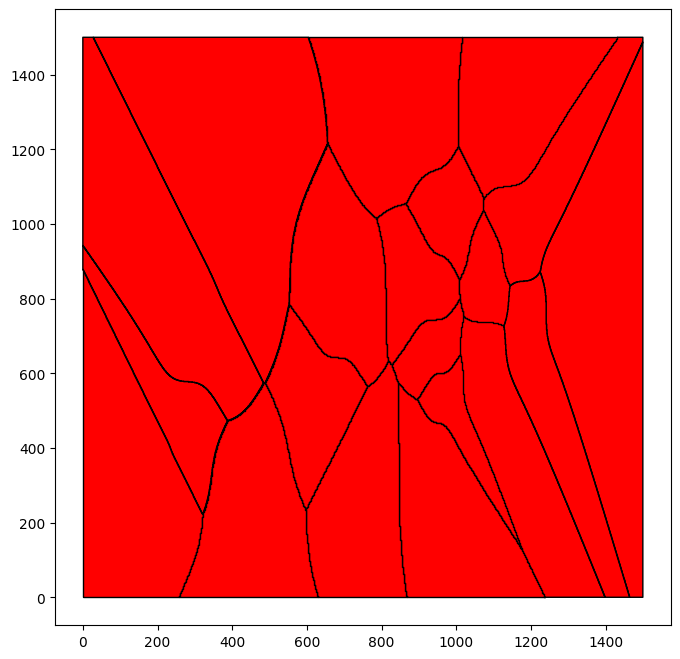

In [ ]:
import rasterio.features
import shapely.geometry
import numpy as np



img = img.astype(np.uint8)

shapes = [item for item in rasterio.features.shapes(img)]

polys = gpd.GeoSeries([])
for x in list(np.unique(img)):
    current_poly = gpd.GeoSeries([shapely.geometry.Polygon(shape[0]["coordinates"][0]) for shape in shapes if shape[1] == x])
    polys = pd.concat([polys.geometry, current_poly.geometry])

gdf = gpd.GeoDataFrame(geometry=polys.geometry, crs=3857)


fig, ax = plt.subplots(1,1, figsize=(10,8))

gdf.plot(ax=ax, edgecolor='black', facecolor='red')

plt.show()



normal voronoi                                             geometry
0  MULTIPOLYGON (((-719144.668 7054736.161, -7049...
clipped voronoi                                             geometry
0  POLYGON ((-697917.227 7055347.575, -695135.042...


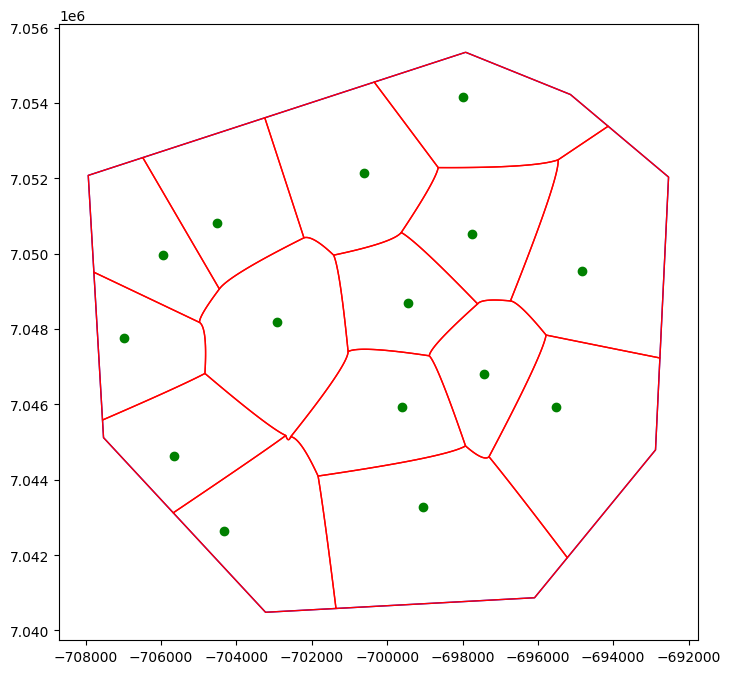

In [92]:
import geopandas as gpd
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import shapely
from shapely import affinity
import random
from shapely.geometry import Polygon, MultiPolygon, MultiPoint, Point, LineString
from line_bender import LineStringBender

def flatten(xss):
    return [x for xs in xss for x in xs]

dv_points = gpd.read_file('dublin_vor_points.geojson').to_crs(3857)
dcc = gpd.read_file('dublin_vor.geojson').to_crs(3857)

centre = dcc.centroid[0]
bounds = dcc.bounds

test_point = dv_points.geometry[0]

for i, point in enumerate(dv_points.geometry):
    dv_points = dv_points.join(pd.DataFrame({f'{i}' : dv_points.distance(point, 'left')}))

dist_matrix = np.asarray(dv_points.drop('geometry', axis=1))
min_dists = [np.min(row[np.nonzero(row)]) for row in dist_matrix]
min_dists_half = [np.min(row[np.nonzero(row)])/2 for row in dist_matrix]

def bez_warp_multi(multishape, rel_dist=[0.1,0.2], off_dist=[100,200]):
    multi_edges = flatten([[LineString(poly.boundary.coords[k:k+2]) for k in range(len(poly.boundary.coords) - 1)] for poly in multishape.geoms])
    
    uni_edges = []
    for edge in multi_edges:
        if not any(e.equals(edge) for e in uni_edges):
            uni_edges.append(edge)

    out_list = []
    for edge in uni_edges:
        edge_bez = LineStringBender(edge, random.uniform(rel_dist[0],rel_dist[1]), random.uniform(off_dist[0],off_dist[1]), 'left').smooth_curve_geom()
        out_list.append(edge_bez)
    return shapely.polygonize(out_list).geoms

dl_tri = dv_points.delaunay_triangles()

dv_vor = MultiPolygon([shape for shape in shapely.voronoi_polygons(MultiPoint(dv_points.geometry)).geoms])

dv_vor_bez = bez_warp_multi(dv_vor)

dv_vor = gpd.GeoDataFrame(geometry=gpd.GeoSeries(dv_vor))#.clip(dcc.geometry[0]))
dv_vor_bez = gpd.GeoDataFrame(geometry=gpd.GeoSeries(dv_vor_bez))#.clip(dcc.geometry[0]))

print("normal voronoi", dv_vor)
print("clipped voronoi", dv_vor.clip(dcc.geometry[0], keep_geom_type=True))

fig, ax = plt.subplots(1,1, figsize=(10,8))

dcc.plot(ax=ax, facecolor='none', edgecolor='blue')

#dv_vor.plot(ax=ax, edgecolor='black', facecolor='yellow', alpha=0.4)
dv_vor_bez.clip(dcc.geometry[0]).plot(ax=ax, edgecolor='red', facecolor='none')
dv_points.plot(ax=ax, color='green')
plt.show()

[<LINESTRING (0 0, 0 1)>, <LINESTRING (0 1, 1 1)>, <LINESTRING (1 1, 1 0)>, <LINESTRING (1 0, 0 0)>]


<Axes: >

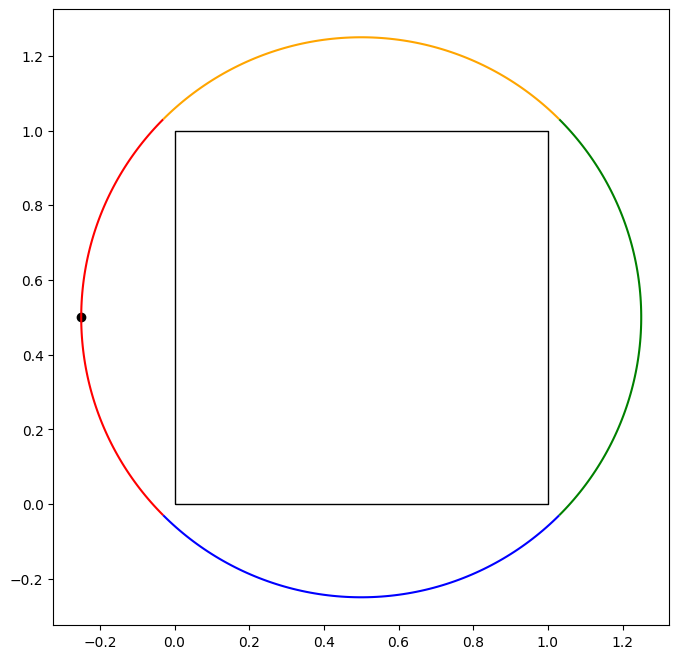

In [ ]:
import numpy as np
import shapely.geometry as geom


# draw unit square
square = geom.Polygon([(0,0), (0,1), (1,1), (1,0)])

from shapely.geometry import Polygon, LineString

b = square.boundary.coords
square_bounds = [LineString(b[k:k+2]) for k in range(len(b) - 1)]
print(square_bounds)

def square_arc(square, radius, n):
    # Define the arc (presumably ezdxf uses a similar convention)
    centerx, centery = square.centroid.x, square.centroid.y
    # In degrees
    start_angle = 45 + (90*n)
    end_angle = start_angle + 90
    numsegments = 100

    # The coordinates of the arc
    theta = np.radians(np.linspace(start_angle, end_angle, numsegments))
    x = centerx + radius * np.cos(theta)
    y = centery + radius * np.sin(theta)

    return gpd.GeoSeries(geom.LineString(np.column_stack([x, y])))


fig, ax = plt.subplots(1,1, figsize=(10,8))



radius = 0.75


arc_0 = square_arc(square, radius, 1)
arc_1 = square_arc(square, radius, 2)
arc_2 = square_arc(square, radius, 3)
arc_3 = square_arc(square, radius, 4)

arc_0_mid = arc_0.interpolate(arc_0.length/2, normalized=False)




gpd.GeoSeries(square).plot(ax=ax, edgecolor='black', facecolor='none')
arc_0.plot(ax=ax, color='red')
arc_0_mid.plot(ax=ax, color='black')
arc_1.plot(ax=ax, color='blue')
arc_2.plot(ax=ax, color='green')
arc_3.plot(ax=ax, color='orange')



POINT (0.25 0.25)


<Axes: >

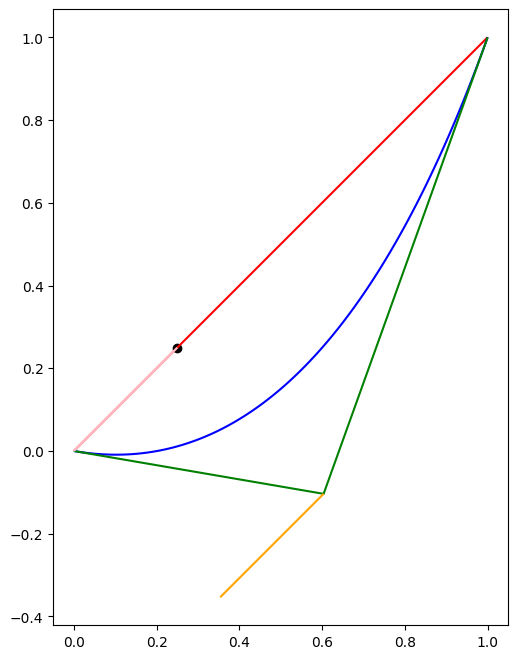

In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import shapely
import os.path
import time

from pathlib import Path
from shapely import voronoi_polygons, MultiPoint, unary_union, LineString
from shapely.ops import nearest_points
from sklearn.cluster import KMeans
from geovoronoi import voronoi_regions_from_coords, points_to_coords

from shapely.wkt import loads

from line_bender import LineStringBender

input_line = loads("LINESTRING(0 0, 1 1)")

#LineStringBender(geometry, relative_distance_along_line, offset_distance_from_line, offset_position)
"""
        :param geometry: LineString shapely geometry
        :type geometry: shapely.geometry.LineString
        :param relative_distance_along_line: relative distance to put the node controller on the line ]0-1]
        :type relative_distance_along_line: float, int
        :param offset_distance_from_line: the offset distance from the line, like a buffer value (meters)
        :type offset_distance_from_line: float, int
        :param offset_distance_from_line: offset position, on the right/left of the line
        :type offset_distance_from_line: str, one of 'right', 'left'
"""
rel_dist = 0.25
offset_dist = 0.5
curve_process = LineStringBender(input_line, rel_dist, offset_dist, 'right')

point_control_on_line = input_line.interpolate(rel_dist, True)

print(curve_process.node_controler_geom())

point_control_line = LineString([
            input_line.coords[0],
            *point_control_on_line.coords[:]
        ])
offset_line = point_control_line.parallel_offset(
            offset_dist,
            'right'
        )

curve_smooth = curve_process.smooth_curve_geom()
curve_raw = curve_process.raw_curve_geom()

fig, ax = plt.subplots(1,1, figsize=(10,8))

gpd.GeoSeries(input_line).plot(ax=ax, color='red')
gpd.GeoSeries(curve_smooth).plot(ax=ax, color='blue')
gpd.GeoSeries(curve_raw).plot(ax=ax, color='green')
gpd.GeoSeries(curve_process.node_controler_geom()).plot(ax=ax, color='black')
gpd.GeoSeries(point_control_line).plot(ax=ax, color='pink')
gpd.GeoSeries(offset_line).plot(ax=ax, color='orange')

In [5]:
import numpy as np
from scipy.special import comb

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """

    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals


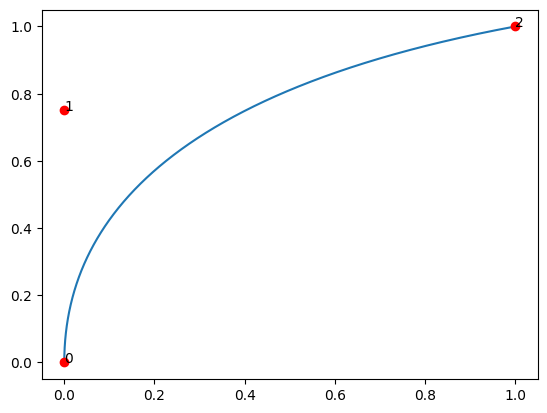

In [13]:
# draw unit square
square = shapely.Polygon([(0,0), (0,1), (1,1), (1,0)])

from shapely.geometry import Polygon, LineString, Point

b = square.boundary.coords


square_verts = [(0,0), (0,0.75), (1,1)]


square_bounds = [LineString(b[k:k+2]) for k in range(len(b) - 1)]
#print(square_bounds)

xpoints = [p[0] for p in square_verts]
ypoints = [p[1] for p in square_verts]

xvals, yvals = bezier_curve(square_verts, nTimes=1000)
plt.plot(xvals, yvals)
plt.plot(xpoints, ypoints, "ro")
for nr in range(len(square_verts)):
    plt.text(square_verts[nr][0], square_verts[nr][1], nr)

plt.show()

[<LINESTRING (0 0, 0 1)>, <LINESTRING (0 1, 1 1)>, <LINESTRING (1 1, 1 0)>, <LINESTRING (1 0, 0 0)>, <LINESTRING (1 0, 1 1)>, <LINESTRING (1 1, 2 1)>, <LINESTRING (2 1, 2 0)>, <LINESTRING (2 0, 1 0)>]
[<LINESTRING (0 0, 0 1)>, <LINESTRING (0 1, 1 1)>, <LINESTRING (1 1, 1 0)>, <LINESTRING (1 0, 0 0)>, <LINESTRING (1 1, 2 1)>, <LINESTRING (2 1, 2 0)>, <LINESTRING (2 0, 1 0)>]


<Axes: >

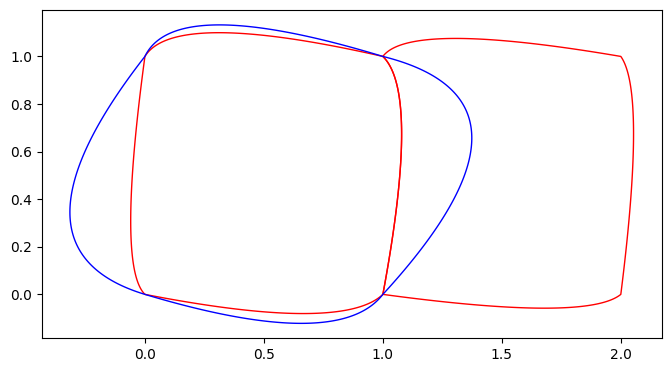

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import shapely
import os.path
import time
import random

from pathlib import Path
from shapely import voronoi_polygons, MultiPoint, unary_union, LineString, Polygon, Point, MultiPolygon
from shapely.ops import nearest_points
from sklearn.cluster import KMeans
from geovoronoi import voronoi_regions_from_coords, points_to_coords

from shapely.wkt import loads

from line_bender import LineStringBender

# draw unit square
square_a = shapely.Polygon([(0,0), (0,1), (1,1), (1,0)])
square_b = shapely.Polygon([(1,0), (1,1), (2,1), (2,0)])

squares = MultiPolygon([square_a, square_b])

def bez_warp(shape, rel_dist=[0.1,1], off_dist=[0.1,1]):
    shape_edges = [LineString(shape.boundary.coords[k:k+2]) for k in range(len(shape.boundary.coords) - 1)]
    out_list = []
    for edge in shape_edges:
        edge_bez = LineStringBender(edge, random.uniform(rel_dist[0],rel_dist[1]), random.uniform(off_dist[0],off_dist[1]), 'left').smooth_curve_geom()
        out_list.append(edge_bez)
    return shapely.polygonize(out_list).geoms

def bez_warp_multi(multishape, rel_dist=[0.1,1], off_dist=[0.1,1]):
    multi_edges = flatten([[LineString(poly.boundary.coords[k:k+2]) for k in range(len(poly.boundary.coords) - 1)] for poly in multishape.geoms])
    
    uni_edges = []
    for edge in multi_edges:
        if not any(e.equals(edge) for e in uni_edges):
            uni_edges.append(edge)

    out_list = []
    for edge in uni_edges:
        edge_bez = LineStringBender(edge, random.uniform(rel_dist[0],rel_dist[1]), random.uniform(off_dist[0],off_dist[1]), 'left').smooth_curve_geom()
        out_list.append(edge_bez)
    return shapely.polygonize(out_list).geoms

def flatten(xss):
    return [x for xs in xss for x in xs]

squares_edges = flatten([[LineString(poly.boundary.coords[k:k+2]) for k in range(len(poly.boundary.coords) - 1)] for poly in squares.geoms])



square_bez = bez_warp(square_a, [0.1,0.2])
squares_bez = bez_warp_multi(squares, [0.1,0.2], [0.1, 0.2])

fig, ax = plt.subplots(1,1,figsize=(8,8))

gpd.GeoSeries(squares_bez).plot(ax=ax, edgecolor='red', facecolor='none')
gpd.GeoSeries(square_bez).plot(ax=ax, edgecolor='blue', facecolor='none')